# Model research and computing for voicing detection

## Project setup

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

datadir = "../data"
gui_train = "../ptdb_tug.gui"
gui_test = "../fda_ue.gui"

## Getting the parameters

In [2]:
def get_zero_crossing(frame):
    """
    Computes zero crossing rate of frame
    """
    count = len(frame)
    countZ = np.sum(np.abs(np.diff(np.sign(frame)))) / 2
    return np.float64(countZ) / np.float64(count-1.0)

In [3]:
def get_log_energy(frame):
    """
    Computes signal energy of frame
    """
    
    if np.float64(len(frame)) <= 0:
        return 0
    else:
        energy = np.sum(frame ** 2) / np.float64(len(frame))

        if energy <= 0:
            return 0
        else:
            log_energy = np.log10(energy)
            return log_energy
    
    return 0

In [4]:
from scipy.signal import correlate

def get_autocorr(frame):
    frame = frame.astype(np.float)
    frame -= frame.mean()
    amax = np.abs(frame).max()
    frame /= amax
    defvalue = (0.0, 1.0)
    corr = correlate(frame, frame)
    # keep the positive part
    corr = corr[round(len(corr)/2):]

    # Find the first minimum
    dcorr = np.diff(corr)
    rmin = np.where(dcorr > 0)[0]
    if len(rmin) > 0:
        rmin1 = rmin[0]
    else:
        return defvalue

    # Find the next peak
    peak = np.argmax(corr[rmin1:]) + rmin1

    # Two features
    r1=corr[1]/corr[0]
    rmax = corr[peak]/corr[0]

    return r1, rmax

## Getting the data

In [5]:
from scipy.io import wavfile

def get_data(gui, windowlength, frameshift, padding):
    
    wav_files = []
    voicing_results = []
    sample_rate = 0

    with open(gui) as f:
        for line in f:
            line = line.strip()
            if len(line) == 0:
                continue
            file_name = os.path.join(datadir, line + ".wav")
            voicing_file = os.path.join(datadir, line + ".f0ref")
            sample_rate, data = wavfile.read(file_name)

            nSamples = len(data)

            # From miliseconds to samples
            ns_windowlength = int(round((windowlength * sample_rate) / 1000))
            ns_frameshift = int(round((frameshift * sample_rate) / 1000))
            ns_padding = int(round((padding * sample_rate) / 1000))

            frames = []
            for ini in range(-ns_padding, nSamples - ns_windowlength + ns_padding + 1, ns_frameshift):
                first_sample = max(0, ini)
                last_sample = min(nSamples, ini + ns_windowlength)
                frame = data[first_sample:last_sample]
                frames.append(frame)

            wav_files += frames

            with open(voicing_file) as v:
                for line in v:
                    if line != "":      
                        if abs(float(line)) == 0:
                            voicing_results.append(False)
                        else:
                            voicing_results.append(True)
            
            wav_files = wav_files[:len(voicing_results)]
            voicing_results = voicing_results[:len(wav_files)]    
            

    np_wav = np.array(wav_files)
    np_voicing = np.array(voicing_results)
    print("nb_samples_wav", np_wav.size)
    print("nb_samples_voicing", np_voicing.size)
    print("sample_rate", sample_rate)
    # np_wav = np_wav[:len(np_voicing)]
    # np_voicing = np_voicing[:len(np_wav)]
        
    formated_data = []
    for data in np_wav:
        zc = get_zero_crossing(data)
        energy = get_log_energy(data)
        r1, rmax = get_autocorr(data)
        formated_data.append([zc, energy, r1, rmax])
        
    np_formated = np.array(formated_data)
    
    return np_formated, np_voicing

In [6]:
formated_data_test, np_voicing_test = get_data(gui_test, 32, 15, 16)
print(formated_data_test.shape)

nb_samples_wav 22140
nb_samples_voicing 22140
sample_rate 20000
(22140, 4)


In [110]:
formated_data_train, np_voicing_train = get_data(gui_train, 32, 10, 0)
formated_data_train.shape

nb_samples_wav 214447104
nb_samples_voicing 139614
sample_rate 48000


(139614, 4)

## Testing the model

### MLP Classifier

In [113]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler()
scaler.fit(formated_data_test)  
X_train = scaler.transform(formated_data_test)

clf = MLPClassifier(solver='lbfgs', alpha=1e-3,hidden_layer_sizes=(25,10), random_state=1)
clf.fit(X_train, np_voicing_test)

res = clf.predict(X_train)

number_failures = 0
for i in range(len(formated_data_test)):
    if res[i] != np_voicing_test[i]:
        number_failures += 1
print(number_failures/len(formated_data_test))

0.07158988256549233


In [112]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler()
scaler.fit(formated_data_train)  
X_train = scaler.transform(formated_data_train)

clf = MLPClassifier(solver='lbfgs', alpha=1e-3,hidden_layer_sizes=(25,10), random_state=1)
clf.fit(X_train, np_voicing_train)

res = clf.predict(X_train)

number_failures = 0
for i in range(len(formated_data_test)):
    if res[i] != np_voicing_test[i]:
        number_failures += 1
print(number_failures/len(formated_data_test))

0.4492321589882565


### DecisionTreeClassifier

In [116]:
from sklearn.ensemble import RandomForestClassifier

decision_clf = RandomForestClassifier(random_state=42)
decision_clf.fit(formated_data_train, np_voicing_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [121]:
res = decision_clf.predict(formated_data_test)

In [122]:
number_failures = 0
for i in range(len(formated_data_test)):
    if res[i] != np_voicing_test[i]:
        number_failures += 1
print(number_failures/len(formated_data_test))

0.47710027100271


In [123]:
from sklearn.mixture import BayesianGaussianMixture

decision_clf = BayesianGaussianMixture(n_components=2)
decision_clf.fit(formated_data_test, np_voicing_test)
res = decision_clf.score(formated_data_test, np_voicing_test)
print(decision_clf)
res = decision_clf.predict(formated_data_test)
number_failures = 0
for i in range(len(formated_data_test)):
    if res[i] != np_voicing_test[i]:
        number_failures += 1
print(number_failures/len(formated_data_test))

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
            degrees_of_freedom_prior=None, init_params='kmeans',
            max_iter=100, mean_precision_prior=None, mean_prior=None,
            n_components=2, n_init=1, random_state=None, reg_covar=1e-06,
            tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
            weight_concentration_prior=None,
            weight_concentration_prior_type='dirichlet_process')
0.47710027100271


## Statistical approximation

In [168]:
def get_feature_data(index):
    
    voiced_signals = []
    unvoiced_signals = []

    i = 0
    while i < len(formated_data_test):
        if np_voicing_test[i]:
            voiced_signals.append(formated_data_test[i][index])
        else:
            unvoiced_signals.append(formated_data_test[i][index])
        i += 1

    voiced_signals = np.sort(np.array(voiced_signals))
    voiced_std = np.std(voiced_signals)
    voiced_mean = np.mean(voiced_signals)
    print("voiced_mean", voiced_mean)
    print("voiced_std", voiced_std)
    voiced_signals = voiced_signals[abs(voiced_signals - voiced_mean) < 3*voiced_std]

    unvoiced_signals = np.sort(np.array(unvoiced_signals))
    unvoiced_std = np.std(unvoiced_signals)
    unvoiced_mean = np.mean(unvoiced_signals)
    print("unvoiced_mean", unvoiced_mean)
    print("unvoiced_std", unvoiced_std)
    unvoiced_signals = unvoiced_signals[abs(unvoiced_signals - unvoiced_mean) < 3*unvoiced_std]
    
    
    return voiced_signals, unvoiced_signals


In [178]:
import scipy.stats as stats
import matplotlib.mlab as mlab

def solve(m1,m2,std1,std2):
  a = 1/(2*std1**2) - 1/(2*std2**2)
  b = m2/(std2**2) - m1/(std1**2)
  c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log(std2/std1)
  return np.roots([a,b,c])

def print_distrubutions(voiced_signals, unvoiced_signals):
    fit_v = stats.norm.pdf(voiced_signals, np.mean(voiced_signals), np.std(voiced_signals))  #this is a fitting indeed
    fit_uv = stats.norm.pdf(unvoiced_signals, np.mean(unvoiced_signals), np.std(unvoiced_signals))  #this is a fitting indeed

    results=solve(np.mean(voiced_signals), np.mean(unvoiced_signals), np.std(voiced_signals), np.std(unvoiced_signals))

    plt.plot(voiced_signals, fit_v, label='Voiced signals')
    plt.plot(unvoiced_signals, fit_uv, label='Unvoiced signals')
    plt.legend()
    plt.show()
    
    print("intersections", results)



### Zero crossing distrubution

voiced_mean 0.07343788136397379
voiced_std 0.06092379885442796
unvoiced_mean 0.2977151353641063
unvoiced_std 0.15262334652074708


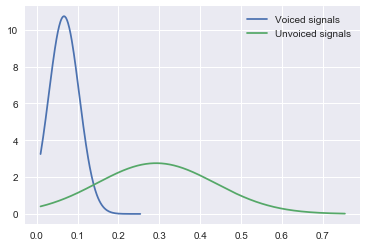

intersections [ 0.13956862 -0.03773243]


In [179]:
voiced_signals, unvoiced_signals = get_feature_data(0)
print_distrubutions(voiced_signals, unvoiced_signals)

### Energy distribution

voiced_mean 2.5503849516653188
voiced_std 1.1206031816730169
unvoiced_mean 2.4349508350504485
unvoiced_std 0.9555855572306294


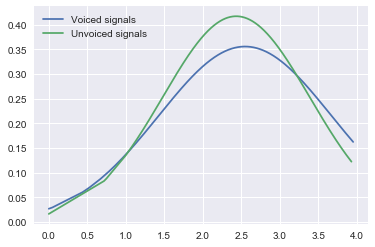

intersections [3.22112836 1.03344603]


In [180]:
voiced_signals, unvoiced_signals = get_feature_data(1)
print_distrubutions(voiced_signals, unvoiced_signals)

### R1 distrubution

voiced_mean 0.9061548802720991
voiced_std 1.0167592535666152
unvoiced_mean 0.5016389063200578
unvoiced_std 12.334876314864031


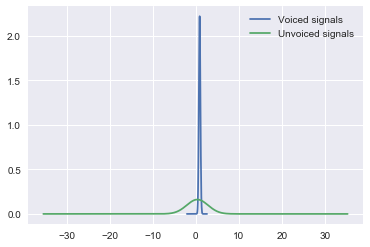

intersections [1.3250281  0.49605555]


In [181]:
voiced_signals, unvoiced_signals = get_feature_data(2)
print_distrubutions(voiced_signals, unvoiced_signals)

### Rmax distrubution

voiced_mean 0.7520441009085105
voiced_std 1.1768569898147816
unvoiced_mean 0.7090659960703576
unvoiced_std 10.35030440505906


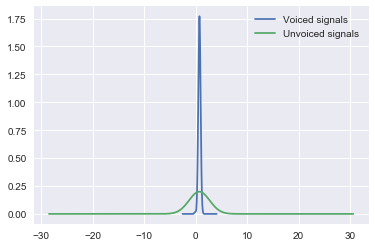

intersections [1.21728693 0.26905511]


In [182]:
voiced_signals, unvoiced_signals = get_feature_data(3)
print_distrubutions(voiced_signals, unvoiced_signals)